/home/mleshashi/thesis-sharma/sraEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [00:07<00:00, 13.66it/s]


Number of documents in the index: 100
Top 3 relevant documents based on combined text and image embeddings:
1. Title: U.S Hispanic population growth has slowed Average annual growth rate in U.S. Hispanic population 4.5% 
 Content: Population growth among U.S. Hispanics has slowed since the start of the decade. From 2015 to 2019, the nation’s Hispanic population grew by an average of 1.9% per year – similar to the 2.1% annual growth between 2010 and 2015, but down from annual growth of more than 3% in earlier years. 
 Score: 1.6033254


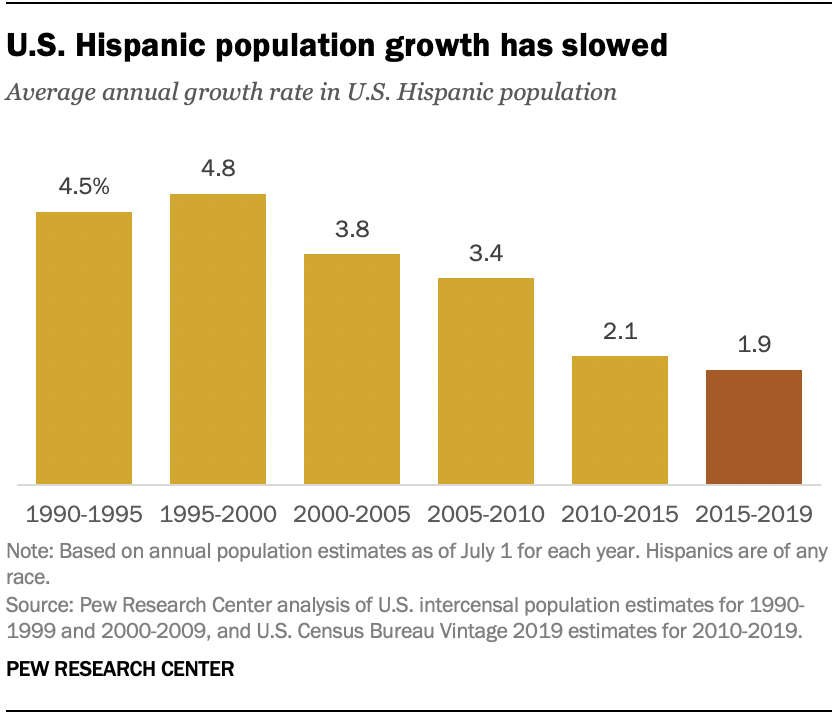

2. Title: U.S Hispanic population reached nearly 61 million in 2019 In millions 
 Content: The U.S. Census Bureau uses this approach, as does Pew Research Center and most other research organizations that conduct public opinion surveys. By this way of counting, the Census Bureau estimates there were roughly 60.6 million Hispanics in the United States as of July 1, 2019, making up 18% of the total national population. 
 Score: 1.5746624


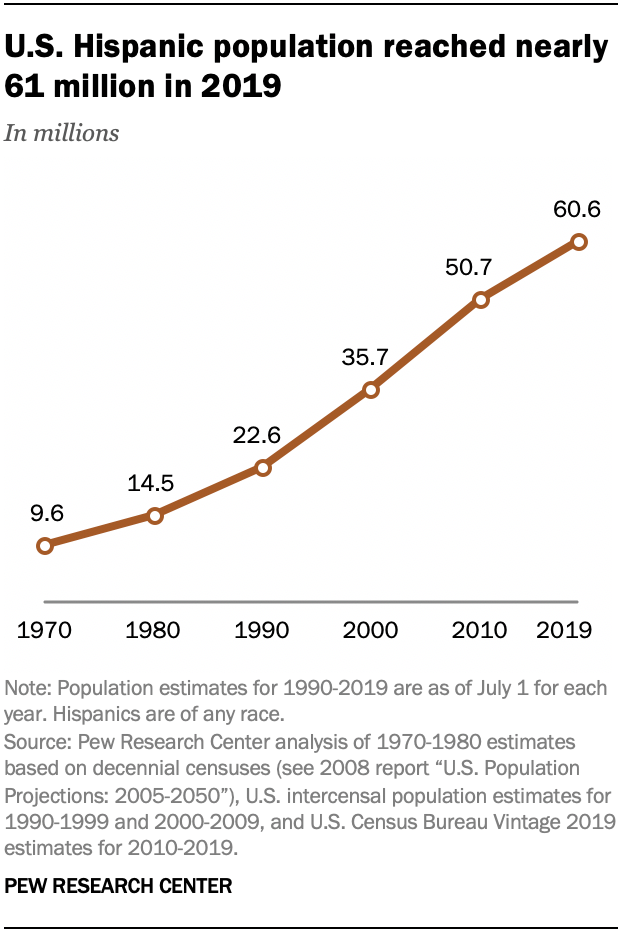

3. Title: U.S Hispanic population reached nearly 61 million in 2019 In millions 
 Content: The U.S. Hispanic population reached a record 60.6 million in 2019, up 930,000 over the previous year and up from 50.7 million in 2010, according to newly released U.S. Census Bureau population estimates. Over the past decade, however, population growth among Hispanics has slowed as the annual number of births to Hispanic women has declined and immigration has decreased, particularly from Mexico.
Population growth among U.S. Hispanics has slowed since the start of the decade. From 2015 to 2019, the nation’s Hispanic population grew by an average of 1.9% per year – similar to the 2.1% annual growth between 2010 and 2015, but down from annual growth of more than 3% in earlier years. 
 Score: 1.5746624


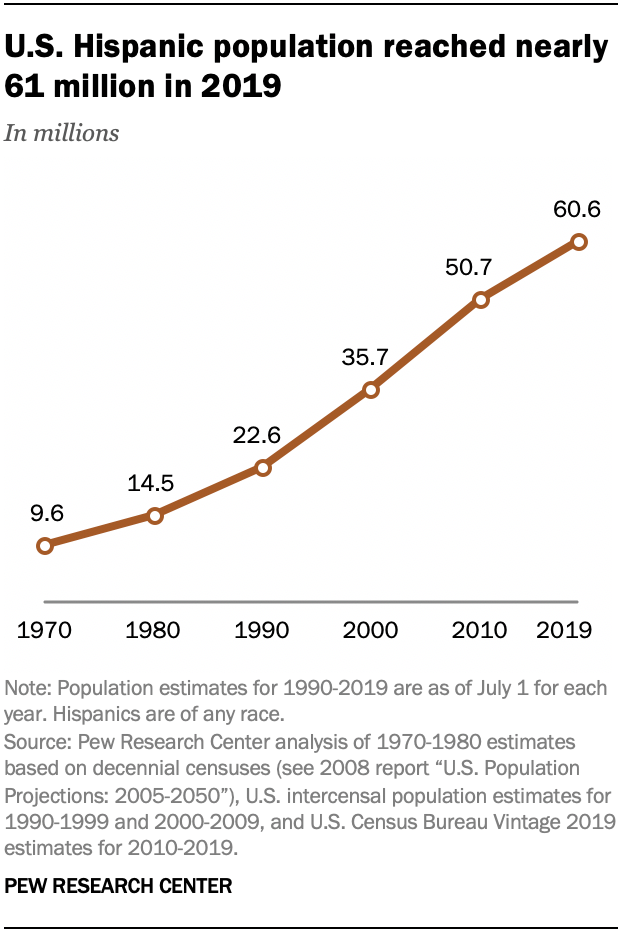

In [1]:
import torch
from elasticsearch import Elasticsearch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np
import pandas as pd
import hashlib
from tqdm import tqdm
import base64
import io

# Load data
# Load your DataFrame
pew = pd.read_csv('../dataset/pew_dataset/metadata.csv')
pew['imgPath'] = pew['imgPath'].str.replace('imgs', '../dataset/pew_dataset/pew_imgs')
statista = pd.read_csv('../dataset/statista_dataset/metadata.csv')
statista['imgPath'] = statista['imgPath'].str.replace('out/two_col/imgs', '../dataset/statista_dataset/statista_imgs')
columns = ['title','caption','imgPath']

# Filtering the DataFrame to include only the specified columns
pew_df = pew[columns]
statista_df = statista[columns]
combined_df = pd.concat([pew_df, statista_df], ignore_index=True)

# Add a new column 'ID' to the DataFrame at the first position
combined_df.insert(0, 'id', combined_df.reset_index().index + 1)
sample_df=combined_df.head(100)

# Initialize CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Elasticsearch setup
es = Elasticsearch(["http://localhost:9200"])
index_name = "clipdocuments"

if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},
                "image_embedding": {"type": "dense_vector", "dims": 512},
                "text_embedding": {"type": "dense_vector", "dims": 512}
            }
        }
    })

# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        # Read the image file
        img_bytes = img_file.read()
        # Encode image bytes to Base64
        base64_img = base64.b64encode(img_bytes).decode("utf-8")
        return base64_img
    

def generate_embedding(image, text):
    # Prepare the input for one image and one text
    inputs = processor(text=[text], images=[image], return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
        image_embedding = output.image_embeds.squeeze(0).numpy().tolist()  # Remove batch dimension if needed
        text_embedding = output.text_embeds.squeeze(0).numpy().tolist()    # Remove batch dimension if needed
        return image_embedding, text_embedding
    

# Indexing documents
for _, row in tqdm(sample_df.iterrows(), total=sample_df.shape[0]):
    image_path = row['imgPath']
    image = Image.open(image_path)
    img_emb, txt_emb = generate_embedding(image, row['title'])
    unique_id = hashlib.sha256((row['title'] + row['caption']).encode('utf-8')).hexdigest()
    
    base64_image = image_to_base64(image_path)
    
    # Index the document
    es.index(index=index_name, id=unique_id, body={
        "title": row['title'],
        "content": row['caption'],
        "image_data": base64_image,
        "image_embedding": img_emb,
        "text_embedding": txt_emb
    })

doc_count = es.count(index=index_name)['count']
print(f"Number of documents in the index: {doc_count}")

# Example text query
text_query = "What is the Hispanic population in the United States?"
dummy_image = Image.new("RGB", (224, 224), color=(255, 255, 255))

# Generate embeddings for the query
_, query_embedding = generate_embedding(dummy_image, text_query)

# Elasticsearch query to find relevant documents based on cosine similarity
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": """
            double image_score = cosineSimilarity(params.query_vector, 'image_embedding') + 1.0;
            double text_score = cosineSimilarity(params.query_vector, 'text_embedding') + 1.0;
            return (image_score + text_score) / 2;  // Average the scores from image and text
            """,
            "params": {"query_vector": query_embedding}
        }
    }
}

response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]
})

print("Top 3 relevant documents based on combined text and image embeddings:")
for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']} \n Content: {doc['content']} \n Score: {hit['_score']}")
    # Optionally decode and display images
    image_bytes = base64.b64decode(doc['image_data'])
    image = Image.open(io.BytesIO(image_bytes))
    image.show()

**Retrieval using image embeddings:**
**openai/clip-vit-base-patch32**

100%|██████████| 100/100 [00:05<00:00, 19.04it/s]


Top 3 relevant documents based on text query:
1. Title: Around one-in-ten young adults in U.S. moved due to COVID-19 outbreak % who say they moved permanently or temporarily for reasons related to the coronavirus outbreak 
 Content: Around one-in-ten adults ages 18 to 29 (9%) say they moved due to the coronavirus outbreak, higher than the share in any other age group. Young adults are among the groups most affected by pandemic-related job losses and by the shutdown of college housing in early spring. 
 Score: 33.32983


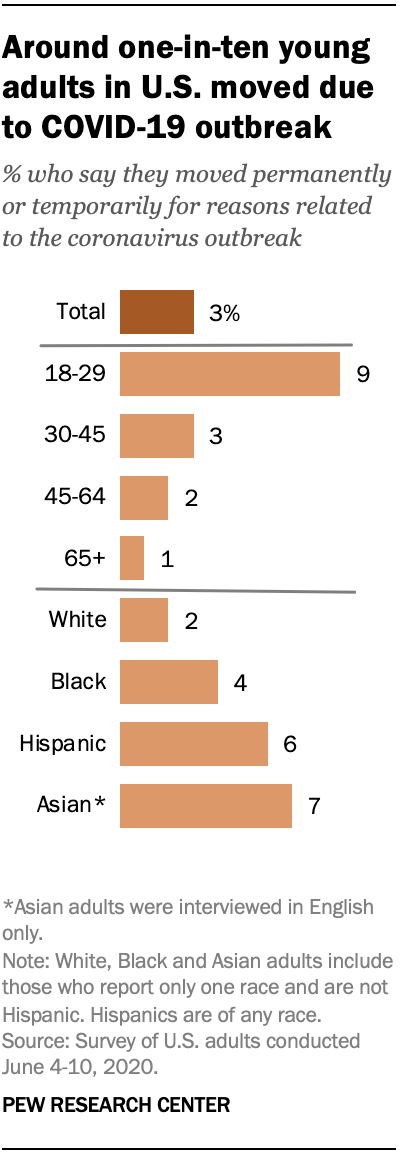

2. Title: U.S Hispanic population growth has slowed Average annual growth rate in U.S. Hispanic population 4.5% 
 Content: Population growth among U.S. Hispanics has slowed since the start of the decade. From 2015 to 2019, the nation’s Hispanic population grew by an average of 1.9% per year – similar to the 2.1% annual growth between 2010 and 2015, but down from annual growth of more than 3% in earlier years. 
 Score: 33.175526


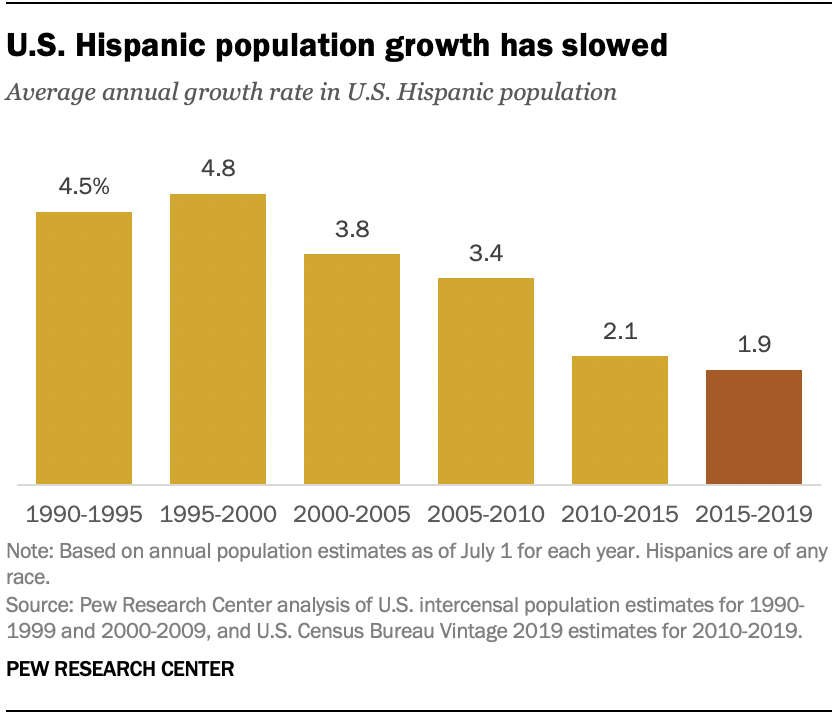

3. Title: Latinos are roughly half of immigrant eligible voters in Florida and Texas % ofimmigrant eligible voters who are Latino 
 Content: Florida and Texas are home to the highest shares of Latinos among immigrant eligible voters. About 54% of naturalized citizens who are eligible voters in Florida are Latino, the highest in the nation. Texas (52%) is the only other state where Latinos make up at least half of immigrant eligible voters. 
 Score: 31.754658


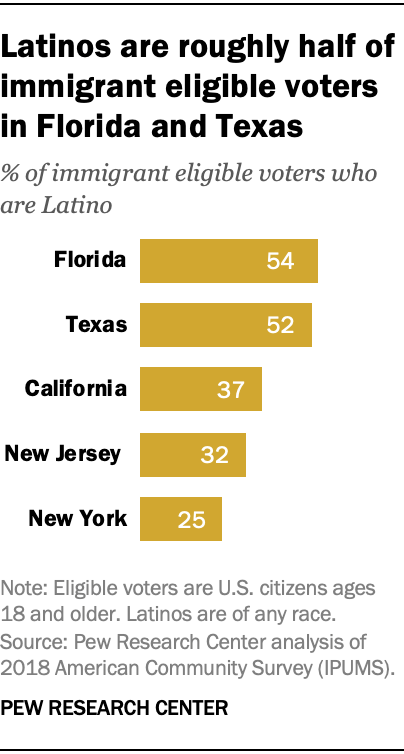

In [16]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import base64
import hashlib
from tqdm import tqdm
import pandas as pd
from elasticsearch import Elasticsearch
import io

# Load data
pew = pd.read_csv('../dataset/pew_dataset/metadata.csv')
pew['imgPath'] = pew['imgPath'].str.replace('imgs', '../dataset/pew_dataset/pew_imgs')
statista = pd.read_csv('../dataset/statista_dataset/metadata.csv')
statista['imgPath'] = statista['imgPath'].str.replace('out/two_col/imgs', '../dataset/statista_dataset/statista_imgs')
columns = ['title', 'caption', 'imgPath']

pew_df = pew[columns]
statista_df = statista[columns]
combined_df = pd.concat([pew_df, statista_df], ignore_index=True)
combined_df.insert(0, 'id', combined_df.reset_index().index + 1)
sample_df = combined_df.head(100)

# Initialize CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
logit_scale = model.logit_scale.exp().item()  # Get the exponential of the logit scale for scaling the cosine similarity

# Elasticsearch setup
es = Elasticsearch(["http://localhost:9200"])
index_name = "imagedocuments"
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},
                "image_embedding": {"type": "dense_vector", "dims": 512}
            }
        }
    })

# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        return base64.b64encode(img_bytes).decode("utf-8")

# Function to generate and normalize image embedding
def generate_image_embedding(image):
    inputs = processor(images=[image], return_tensors="pt")
    with torch.no_grad():
        output = model.get_image_features(**inputs).squeeze(0)
        return (output / output.norm(p=2, dim=-1, keepdim=True)).numpy().tolist()

# Indexing only images
for _, row in tqdm(sample_df.iterrows(), total=sample_df.shape[0]):
    image_path = row['imgPath']
    image = Image.open(image_path)
    img_emb = generate_image_embedding(image)
    unique_id = hashlib.sha256((row['title'] + row['caption']).encode('utf-8')).hexdigest()
    base64_image = image_to_base64(image_path)
    
    es.index(index=index_name, id=unique_id, body={
        "title": row['title'],
        "content": row['caption'],
        "image_data": base64_image,
        "image_embedding": img_emb
    })

# Text query example and fetching images based on text query
text_query = "What is the Hispanic population in the United States?"
inputs = processor(text=[text_query], padding=True, return_tensors="pt")
with torch.no_grad():
    text_features = model.get_text_features(**inputs).squeeze(0)
    text_features = (text_features / text_features.norm(p=2, dim=-1, keepdim=True)).numpy().tolist()

# Elasticsearch query to find relevant images
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'image_embedding') * params.logit_scale + 1.0",
            "params": {
                "query_vector": text_features,
                "logit_scale": logit_scale
            }
        }
    }
}

response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]
})

print("Top 3 relevant documents based on text query:")
for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']} \n Content: {doc['content']} \n Score: {hit['_score']}")
    # Optionally decode and display images
    image_bytes = base64.b64decode(doc['image_data'])
    image = Image.open(io.BytesIO(image_bytes))
    image.show()
   

**using openai/clip-vit-large-patch14**

Using device: cuda


100%|██████████| 100/100 [00:04<00:00, 20.67it/s]

Top 3 relevant documents based on text query:
1. Title: U.S Hispanic population reached nearly 61 million in 2019 In millions 
 Content: The U.S. Census Bureau uses this approach, as does Pew Research Center and most other research organizations that conduct public opinion surveys. By this way of counting, the Census Bureau estimates there were roughly 60.6 million Hispanics in the United States as of July 1, 2019, making up 18% of the total national population. 
 Score: 28.086288


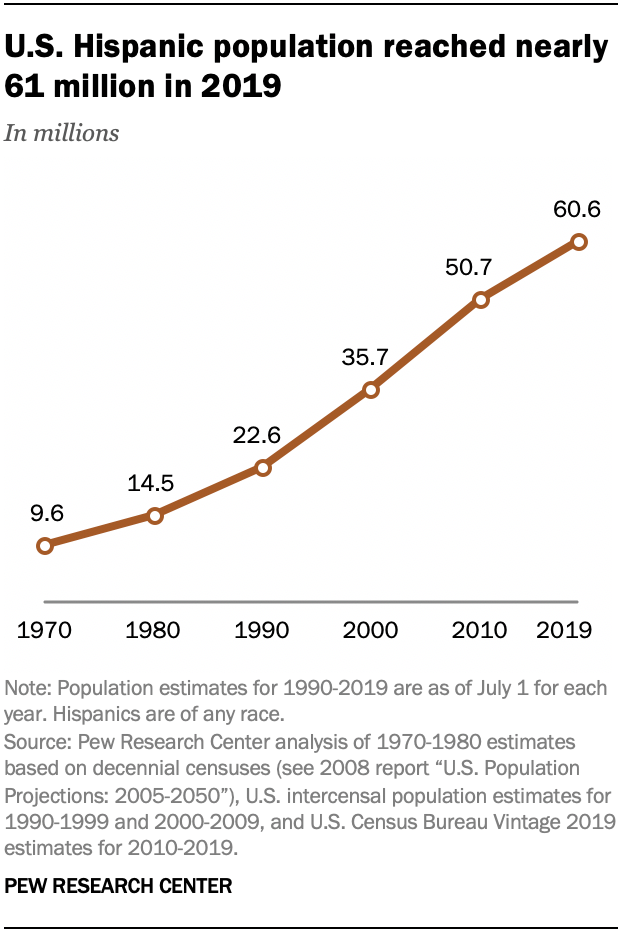

2. Title: U.S. Hispanic population reached nearly 61 million in 2019 In millions 
 Content: The U.S. Hispanic population reached 60.6 million in 2019, up from 50.7 million in 2010. This makes Hispanics the nation’s second-fastest-growing racial or ethnic group after Asian Americans. Hispanics made up 18% of the U.S. population in 2019, up from 16% in 2010 and just 5% in 1970. 
 Score: 27.850718


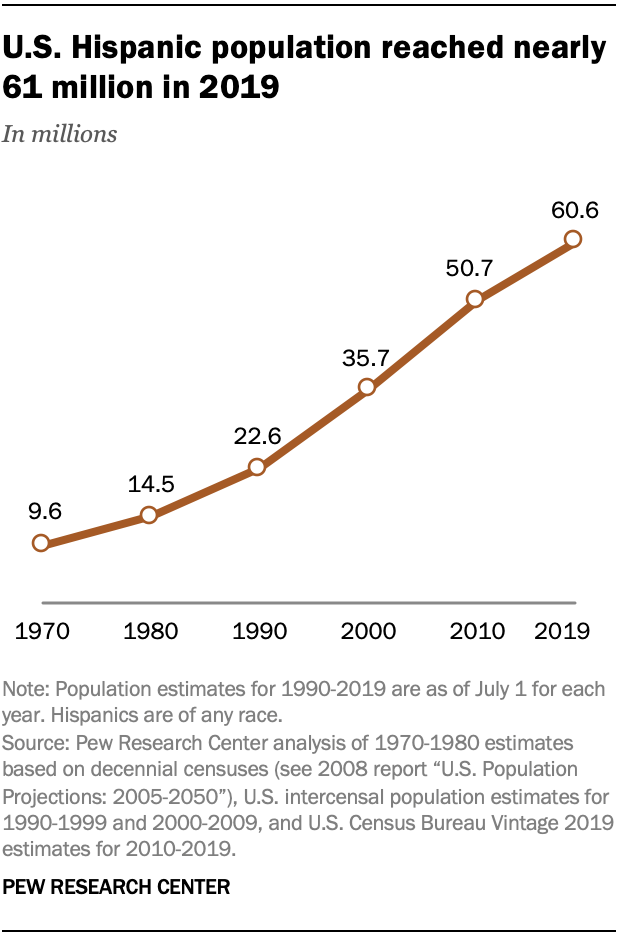

3. Title: Foreign-born population in the United States, 1850-2018 
 Content: The foreign-born population residing in the U.S. reached a record 44.8 million, or 13.7% of the U.S. population, in 2018. This immigrant population has more than quadrupled since the 1960s, when the 1965 Immigration and Naturalization Act took effect. Though growth has begun to slow in recent years, the number of immigrants living in the United States is projected to almost double by 2065. 
 Score: 27.768604


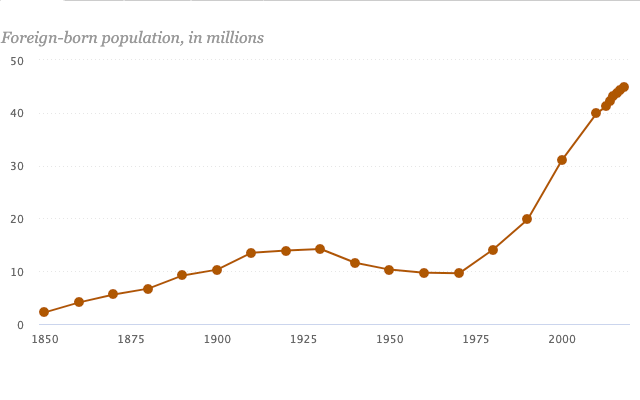

In [23]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import base64
import hashlib
from tqdm import tqdm
import pandas as pd
from elasticsearch import Elasticsearch
import io

# Load data
pew = pd.read_csv('../dataset/pew_dataset/metadata.csv')
pew['imgPath'] = pew['imgPath'].str.replace('imgs', '../dataset/pew_dataset/pew_imgs')
statista = pd.read_csv('../dataset/statista_dataset/metadata.csv')
statista['imgPath'] = statista['imgPath'].str.replace('out/two_col/imgs', '../dataset/statista_dataset/statista_imgs')
columns = ['title', 'caption', 'imgPath']

pew_df = pew[columns]
statista_df = statista[columns]
combined_df = pd.concat([pew_df, statista_df], ignore_index=True)
combined_df.insert(0, 'id', combined_df.reset_index().index + 1)
sample_df = combined_df.head(100)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
logit_scale = model.logit_scale.exp().item()  # Get the exponential of the logit scale for scaling the cosine similarity

# Elasticsearch setup
es = Elasticsearch(["http://localhost:9200"])
index_name = "imagedocuments14"
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},
                "image_embedding": {"type": "dense_vector", "dims": 768}
            }
        }
    })

# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        return base64.b64encode(img_bytes).decode("utf-8")

# Function to generate and normalize image embedding
def generate_image_embedding(image):
    #image = image.convert("RGB")  # Ensure image is in RGB
    inputs = processor(images=[image], return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.get_image_features(**inputs).squeeze(0)
        normalized_output = (output / output.norm(p=2, dim=-1, keepdim=True))
        return normalized_output.cpu().numpy().tolist()  # Move back to CPU for Elasticsearch indexing

# Indexing only images
for _, row in tqdm(sample_df.iterrows(), total=sample_df.shape[0]):
    image_path = row['imgPath']
    image = Image.open(image_path)
    img_emb = generate_image_embedding(image)
    unique_id = hashlib.sha256((row['title'] + row['caption']).encode('utf-8')).hexdigest()
    base64_image = image_to_base64(image_path)
    
    es.index(index=index_name, id=unique_id, body={
        "title": row['title'],
        "content": row['caption'],
        "image_data": base64_image,
        "image_embedding": img_emb
    })

# Text query example and fetching images based on text query
text_query = "What is the Hispanic population in the United States?"
inputs = processor(text=[text_query], padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    text_features = model.get_text_features(**inputs).squeeze(0)
    text_features = (text_features / text_features.norm(p=2, dim=-1, keepdim=True)).cpu().numpy().tolist() # Move back to CPU for Elasticsearch

# Elasticsearch query to find relevant images
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'image_embedding') * params.logit_scale + 1.0",
            "params": {
                "query_vector": text_features,
                "logit_scale": logit_scale
            }
        }
    }
}

response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]
})

print("Top 3 relevant documents based on text query:")
for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']} \n Content: {doc['content']} \n Score: {hit['_score']}")
    # Optionally decode and display images
    image_bytes = base64.b64decode(doc['image_data'])
    image = Image.open(io.BytesIO(image_bytes))
    image.show()

Top 3 relevant documents based on text query:
1. Title: More than half of U.S refugees in 2019 were from D.R Congo and Burma Number ofrefugees entering the U.S. infiscal 2019, by origin country 
 Content: In fiscal 2019, a total of 30,000 refugees were resettled in the U.S. The largest origin group of refugees was the Democratic Republic of the Congo, followed by Burma (Myanmar), Ukraine, Eritrea and Afghanistan. Among all refugees admitted in fiscal year 2019, 4,900 are Muslims (16%) and 23,800 are Christians (79%). Texas, Washington, New York and California resettled more than a quarter of all refugees admitted in fiscal 2018. 
 Score: 29.4633


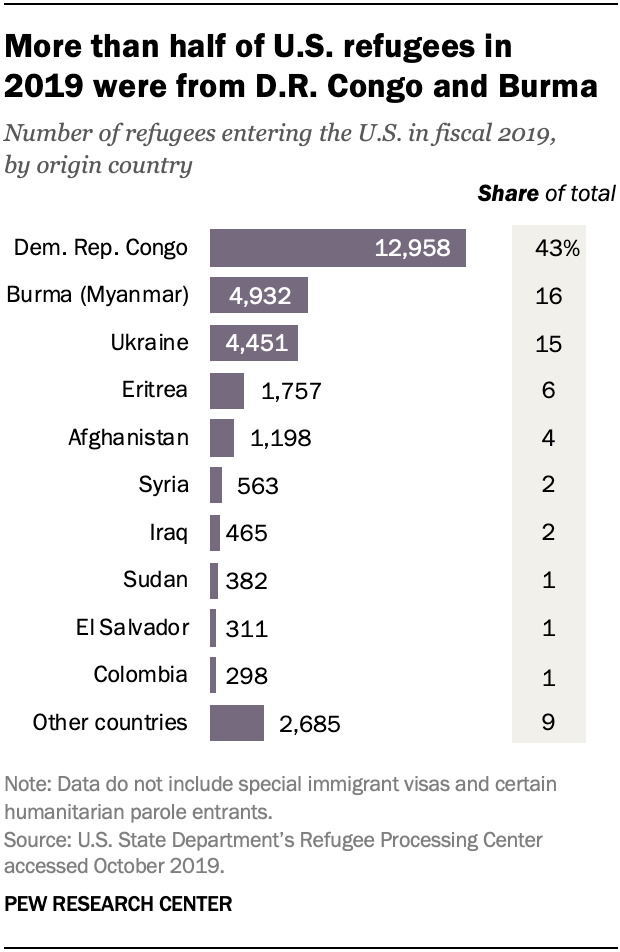

2. Title: Immigrant share of U.S population nears historic high % of U.S. population that is foreign born 
 Content: The U.S. foreign-born population reached a record 44.8 million in 2018. Since 1965, when U.S. immigration laws replaced a national quota system, the number of immigrants living in the U.S. has more than quadrupled. Immigrants today account for 13.7% of the U.S. population, nearly triple the share (4.8%) in 1970. However, today’s immigrant share remains below the record 14.8% share in 1890, when 9.2 million immigrants lived in the U.S. 
 Score: 29.151241


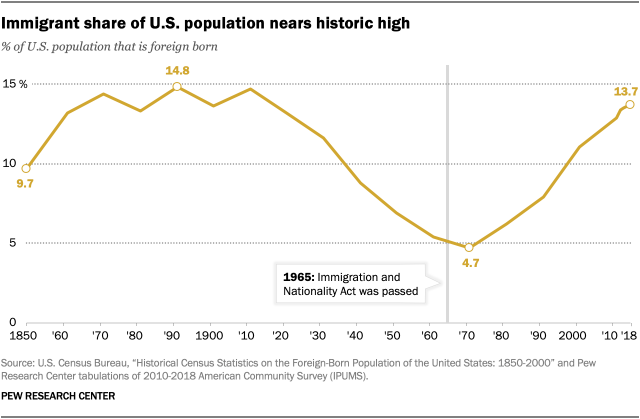

3. Title: U.S Hispanic population reached nearly 61 million in 2019 In millions 
 Content: The U.S. Census Bureau uses this approach, as does Pew Research Center and most other research organizations that conduct public opinion surveys. By this way of counting, the Census Bureau estimates there were roughly 60.6 million Hispanics in the United States as of July 1, 2019, making up 18% of the total national population. 
 Score: 28.41197


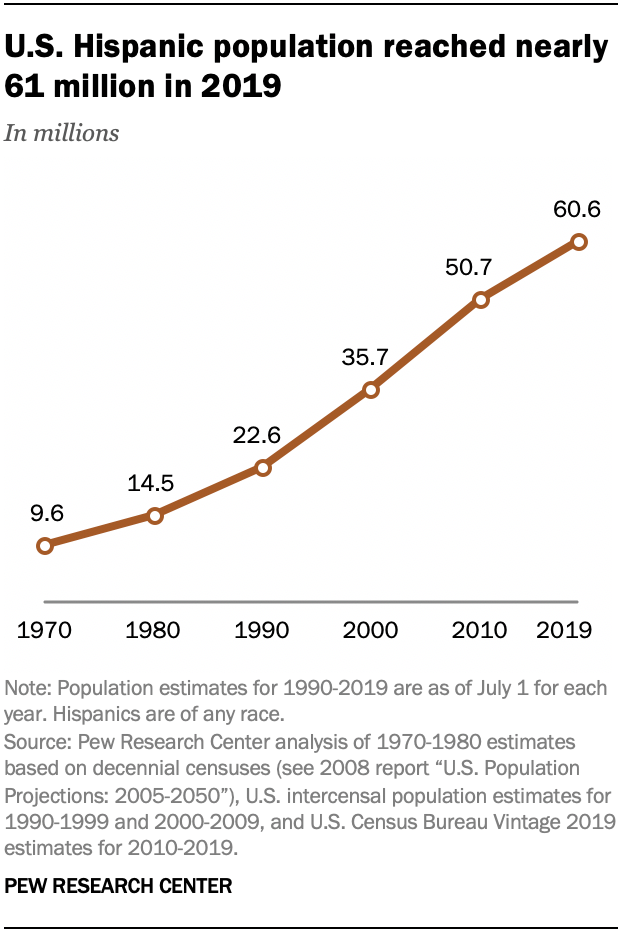

In [24]:
# Text query example and fetching images based on text query
text_query = "Foreign-born population in the United States"
inputs = processor(text=[text_query], padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    text_features = model.get_text_features(**inputs).squeeze(0)
    text_features = (text_features / text_features.norm(p=2, dim=-1, keepdim=True)).cpu().numpy().tolist() # Move back to CPU for Elasticsearch

# Elasticsearch query to find relevant images
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'image_embedding') * params.logit_scale + 1.0",
            "params": {
                "query_vector": text_features,
                "logit_scale": logit_scale
            }
        }
    }
}

response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]
})

print("Top 3 relevant documents based on text query:")
for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']} \n Content: {doc['content']} \n Score: {hit['_score']}")
    # Optionally decode and display images
    image_bytes = base64.b64decode(doc['image_data'])
    image = Image.open(io.BytesIO(image_bytes))
    image.show()

**Indexing all the images and saving it to a new field in the existing Elasticsearch index**

In [30]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import base64
import hashlib
from tqdm import tqdm
import pandas as pd
from elasticsearch import Elasticsearch
import io

# Load data
pew = pd.read_csv('../dataset/pew_dataset/metadata.csv')
pew['imgPath'] = pew['imgPath'].str.replace('imgs', '../dataset/pew_dataset/pew_imgs')
statista = pd.read_csv('../dataset/statista_dataset/metadata.csv')
statista['imgPath'] = statista['imgPath'].str.replace('out/two_col/imgs', '../dataset/statista_dataset/statista_imgs')
columns = ['title', 'caption', 'imgPath']

pew_df = pew[columns]
statista_df = statista[columns]
combined_df = pd.concat([pew_df, statista_df], ignore_index=True)
combined_df.insert(0, 'id', combined_df.reset_index().index + 1)
#sample_df = combined_df.head(100)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
logit_scale = model.logit_scale.exp().item()  # Get the exponential of the logit scale for scaling the cosine similarity

# Elasticsearch setup
es = Elasticsearch(["http://localhost:9200"])
index_name = "documents"
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},
                "image_embedding": {"type": "dense_vector", "dims": 768}
            }
        }
    })
# The document already exist, with the new field name 'clip_embedding'

# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        img_bytes = img_file.read()
        return base64.b64encode(img_bytes).decode("utf-8")

# Function to generate and normalize image embedding
def generate_image_embedding(image):
    #image = image.convert("RGB")  # Ensure image is in RGB
    inputs = processor(images=[image], return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.get_image_features(**inputs).squeeze(0)
        normalized_output = (output / output.norm(p=2, dim=-1, keepdim=True))
        return normalized_output.cpu().numpy().tolist()  # Move back to CPU for Elasticsearch indexing

# Indexing only images
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    image_path = row['imgPath']
    image = Image.open(image_path)
    img_emb = generate_image_embedding(image)
    
    # Combine title and caption to form a text used for hashing
    combined_text = f"{row['title']}. {row['caption']}"
    #combined_text = row['title'] + row['caption']
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # Update the document in Elasticsearch with the new clip_embedding
    es.update(index=index_name, id=unique_id, body={
        "doc": {
            "clip_embedding": img_emb
        }
    })

Using device: cuda


100%|██████████| 29354/29354 [35:36<00:00, 13.74it/s] 


Top 3 relevant documents based on text query:
1. Title: Overview of the U S. Hispanic Population  
 Content: Latinos of Mexican origin are by far the largest national origin group, representing about 60 percent of the Hispanic population. Puerto Ricans are the next largest and they are far behind, making up just 10 percent of all Latinos. The rest of the Hispanic population is divided among persons who trace their roots to many different nations. 
 Score: 34.995018


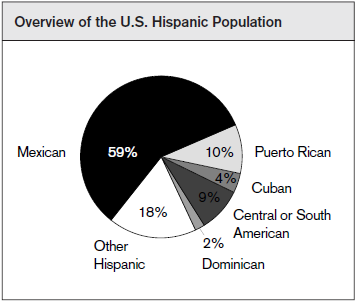

2. Title: U.S. Hispanic Population in 2012 
 Content: The Hispanic population grew to 53 million in 2012, a 50% increase since 2000 and nearly six times the population in 1970, according to the most recent U.S. Census Bureau data. Meanwhile, the overall U.S. population increased by only 12% from 2000 to 2012. Hispanic population growth accounted for more than half of the country’s growth in this time period.
Much of the growth is occurring in a relatively small geographic area. A Pew Research Center analysis last year found that the 10 largest counties by Hispanic population accounted for 22% of the national Hispanic population growth between 2000 and 2011. Half of these counties are located in California. 
 Score: 32.168358


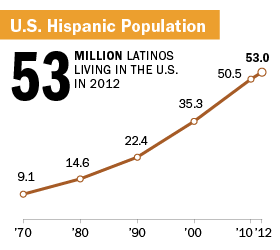

3. Title: Figure 1 U.S. Hispanic Population, by Origin, 2010 (in thousands) 
 Content: Among the 50.7 million Hispanics in the United States, nearly two-thirds (65%), or 33 million, self-identify as being of Mexican origin, according to tabulations of the 2010 American Community Survey (ACS) by the Pew Hispanic Center, a project of the Pew Research Center. No other Hispanic subgroup rivals the size of the Mexican-origin population. Puerto Ricans, the nation’s second largest Hispanic origin group, make up just 9% of the total Hispanic population in the 50 states and the District of Columbia. 
 Score: 31.266613


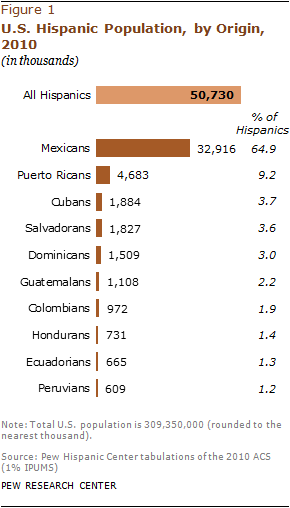

In [31]:
# Text query example and fetching images based on text query
text_query = "What is the Hispanic population in the United States?"
inputs = processor(text=[text_query], padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    text_features = model.get_text_features(**inputs).squeeze(0)
    text_features = (text_features / text_features.norm(p=2, dim=-1, keepdim=True)).cpu().numpy().tolist() # Move back to CPU for Elasticsearch

# Elasticsearch query to find relevant images
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'clip_embedding') * params.logit_scale + 1.0",
            "params": {
                "query_vector": text_features,
                "logit_scale": logit_scale
            }
        }
    }
}

response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]
})

print("Top 3 relevant documents based on text query:")
for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']} \n Content: {doc['content']} \n Score: {hit['_score']}")
    # Optionally decode and display images
    image_bytes = base64.b64decode(doc['image_data'])
    image = Image.open(io.BytesIO(image_bytes))
    image.show()